#### Copyright 2018 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Intro to Modeling


**Learning Objectives:**
* Become familiar with pandas for handling small datasets
* Use the tf.Estimator and Feature Column API to experiment with feature transformations
* Use visualizations and run experiments to understand the value of feature transformations

Please **make a copy** of this Colab notebook before starting this lab. To do so, choose **File**->**Save a copy in Drive**.

## Setup

Let's start by importing our dependencies.

In [ ]:
%reset -f
import numpy as np
import pandas as pd
import math

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Pandas, a helpful data analysis library for in-memory dataset

We use a package called [Pandas](http://pandas.pydata.org/) for reading in our data, exploring our data and doing some basic processing. It is really helpful for datasets that fit in memory! And it has some nice integrations, as you will see.

First we set up some options to control how items are displayed and the maximum number of rows to show when displaying a table.  Feel free to change this setup to whatever you'd like.

In [ ]:
# Set pandas output display to have one digit for decimal places and limit it to
# printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

### Load the dataset with pandas
The car data set we will be using in this lab is provided as a comma separated file without a header row.  In order for each column to have a meaningful header name we must provide it.  We get the information about the columns from the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile).

We will use the features of the car, to try to predict its price.


In [ ]:
# Provide the names for the columns since the CSV file with the data does
# not have a header row.
feature_names = ['symboling', 'normalized-losses', 'make', 'fuel-type',
        'aspiration', 'num-doors', 'body-style', 'drive-wheels',
        'engine-location', 'wheel-base', 'length', 'width', 'height', 'weight',
        'engine-type', 'num-cylinders', 'engine-size', 'fuel-system', 'bore',
        'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
        'highway-mpg', 'price']


# Load in the data from a CSV file that is comma separated.
car_data = pd.read_csv('https://storage.googleapis.com/mledu-datasets/cars_data.csv',
                        sep=',', names=feature_names, header=None, encoding='latin-1')


# We'll then randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of Stochastic Gradient
# Descent.
car_data = car_data.reindex(np.random.permutation(car_data.index))

print("Data set loaded. Num examples: ", len(car_data))

Data set loaded. Num examples:  205


This is a really small dataset! Only 205 examples.

For simplicity in this codelab, we do not split the data further into training and validation. But you MUST do this on real datasets, or else you will overfit to your single dataset.

## Task 0: Use pandas to explore and prepare the data

- Use Pandas to inspect the data and manually curate a list of numeric_feature_names and categorical_feature_names.


Useful functions:
- `type()` called on any Python object describes the type of the object
- `dataframe[4:7]` pulls out rows 4, 5, 6 in a Pandas dataframe
- `dataframe[['mycol1', 'mycol2']]` pulls out the two requested columns into a new Pandas dataframe
- `dataframe['mycol1']` returns a Pandas series -- not a dataframe!
- `dataframe.describe()` prints out statistics for each dataframe column

In [ ]:
car_data[4:7]

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,weight,engine-type,num-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
165,1,168,toyota,gas,std,two,sedan,rwd,front,94.50,168.70,64.00,52.60,2265,dohc,four,98,mpfi,3.24,3.08,9.40,112,6600,26,29,9298
60,0,115,mazda,gas,std,four,sedan,fwd,front,98.80,177.80,66.50,55.50,2410,ohc,four,122,2bbl,3.39,3.39,8.60,84,4800,26,32,8495
75,1,?,mercury,gas,turbo,two,hatchback,rwd,front,102.70,178.40,68.00,54.80,2910,ohc,four,140,mpfi,3.78,3.12,8.00,175,5000,19,24,16503


In [ ]:
numeric_feature_names = ['symboling', 'normalized-losses', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-size', 'horsepower',
        'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke',
         'compression-ratio']

categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))
#correct soulution should pass this assert statement
assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

In [ ]:
#@title Solution (to view code, from cell's menu, select Form -> Show Code)
numeric_feature_names = ['symboling', 'normalized-losses', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-size', 'horsepower',
        'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke',
         'compression-ratio']

categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

In [ ]:
# Run to inspect numeric features.
car_data[numeric_feature_names]

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
119,1,119,93.70,157.30,63.80,50.80,2128,98,102,5500,24,30,3.03,3.39,7.60
81,3,153,96.30,173.00,65.40,49.40,2328,122,88,5000,25,32,3.35,3.46,8.50
35,0,110,96.50,163.40,64.00,54.50,2010,92,76,6000,30,34,2.91,3.41,9.20
203,-1,95,109.10,188.80,68.90,55.50,3217,145,106,4800,26,27,3.01,3.40,23.00
165,1,168,94.50,168.70,64.00,52.60,2265,98,112,6600,26,29,3.24,3.08,9.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2,94,97.30,171.70,65.50,55.70,2319,97,68,4500,37,42,3.01,3.40,23.00
104,3,194,91.30,170.70,67.90,49.70,3071,181,160,5200,19,25,3.43,3.27,9.00
90,1,128,94.50,165.30,63.80,54.50,2017,103,55,4800,45,50,2.99,3.47,21.90
10,2,192,101.20,176.80,64.80,54.30,2395,108,101,5800,23,29,3.50,2.80,8.80


In [ ]:
# Run to inspect categorical features.
car_data[categorical_feature_names]

,drive-wheels,engine-type,num-doors,body-style,num-cylinders,fuel-type,aspiration,fuel-system,engine-location,make
119,fwd,ohc,two,hatchback,four,gas,turbo,spdi,front,plymouth
81,fwd,ohc,two,hatchback,four,gas,std,2bbl,front,mitsubishi
35,fwd,ohc,four,sedan,four,gas,std,1bbl,front,honda
203,rwd,ohc,four,sedan,six,diesel,turbo,idi,front,volvo
165,rwd,dohc,two,sedan,four,gas,std,mpfi,front,toyota
...,...,...,...,...,...,...,...,...,...,...
187,fwd,ohc,four,sedan,four,diesel,turbo,idi,front,volkswagen
104,rwd,ohcv,two,hatchback,six,gas,std,mpfi,front,nissan
90,fwd,ohc,two,sedan,four,diesel,std,idi,front,nissan
10,rwd,ohc,two,sedan,four,gas,std,mpfi,front,bmw


In [ ]:
# Coerce the numeric features to numbers. This is necessary because the model
# crashes because not all the values are numeric.
for feature_name in numeric_feature_names + [LABEL]:
  car_data[feature_name] = pd.to_numeric(car_data[feature_name], errors='coerce')

# Fill missing values with 0.
# Is this an OK thing to do? You may want to come back and revisit this decision later.
car_data.fillna(0, inplace=True)

## Task 1: Make your best model with numeric features. No normalization allowed.

Modify the model provided below to achieve the lowest eval loss. You may want to change various hyperparameters:
- learning rate
- choice of optimizer
- hidden layer dimensions -- make sure your choice here makes sense given the number of training examples
- batch size
- num training steps
- (anything else you can think of changing)

Do not use the `normalizer_fn` arg on `numeric_column`.

In [ ]:
# This code "works", but because of bad hyperparameter choices it gets NaN loss
# during training. Try fixing this.

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=t

In [ ]:
#@title Possible solution
# Here is one possible solution:
# The only necessary change to fix the NaN training loss was the choice of optimizer.

# Changing other parameters could improve model quality, but take it with a
# grain of salt. The dataset is very small.

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the 
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



### Visualize your model's predictions

After you have a trained model, it may be helpful to understand how your model's inference differs from the actual data.

This helper function `scatter_plot_inference` does that for you. Real data is in grey. Your model's predictions are in orange.


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpr4_1wu08/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


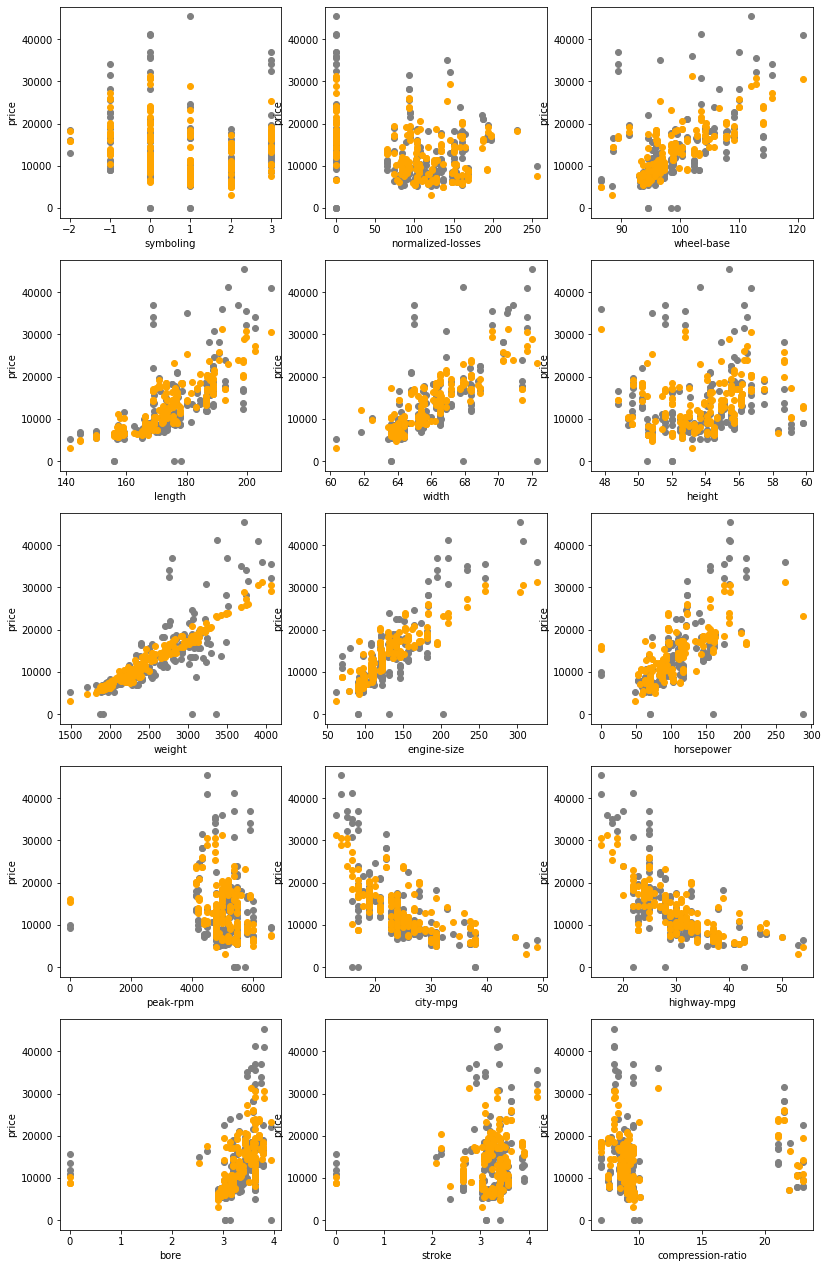

In [ ]:
from matplotlib import pyplot as plt


def scatter_plot_inference_grid(est, x_df, feature_names):
  """Plots the predictions of the model against each feature.
  
  Args:
    est: The trained tf.Estimator.
    x_df: The pandas dataframe with the input data (used to create
      predict_input_fn).
    feature_names: An iterable of string feature names to plot.
  """
  def scatter_plot_inference(axis,
                             x_axis_feature_name,
                             y_axis_feature_name,
                             predictions):
    """Generate one subplot."""
    # Plot the real data in grey.
    y_axis_feature_name = 'price'
    axis.set_ylabel(y_axis_feature_name)
    axis.set_xlabel(x_axis_feature_name)
    axis.scatter(car_data[x_axis_feature_name],
                 car_data[y_axis_feature_name],
                 c='grey')

    # Plot the predicted data in orange.
    axis.scatter(car_data[x_axis_feature_name], predictions, c='orange')

  predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

  predictions = [
    x['predictions'][0]
    for x in est.predict(predict_input_fn)
  ]
  
  num_cols = 3
  num_rows = int(math.ceil(len(feature_names)/float(num_cols)))
  f, axarr = plt.subplots(num_rows, num_cols)
  size = 4.5
  f.set_size_inches(num_cols*size, num_rows*size)
  
  for i, feature_name in enumerate(numeric_feature_names):
    axis = axarr[int(i/num_cols), i%num_cols]
    scatter_plot_inference(axis, feature_name, 'price', predictions)
  plt.show()

scatter_plot_inference_grid(est, x_df, numeric_feature_names)

## Task 2: Take your best numeric model from earlier. Add normalization.

### Add normalization to your best numeric model from earlier

- You decide what type of normalization to add, and for which features
- You will need to use the `normalizer_fn` arg on [`numeric_column`](https://g3doc.corp.google.com/learning/brain/public/g3doc/api_docs/python/tf/feature_column/numeric_column.md?cl=head)
    - An example of a silly normalizer_fn that shifts inputs down by 1, and then negates the value:
    
         normalizer_fn = lambda x: tf.neg(tf.subtract(x, 1))

- You may find these pandas functions helpful:
    - dataframe.mean()['your_feature_name']
    - dataframe.std()['your_feature_name']
- You will need to retune the hyperparameters from earlier.


**Does normalization improve model quality on this dataset? Why or why not?**

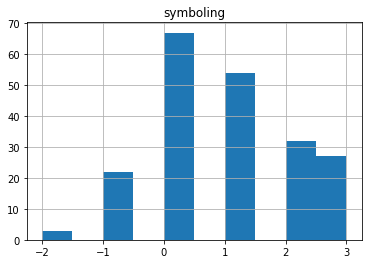

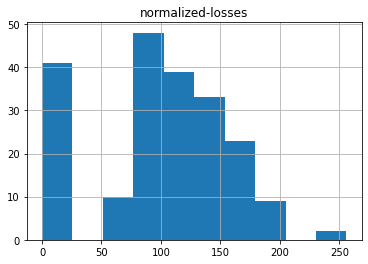

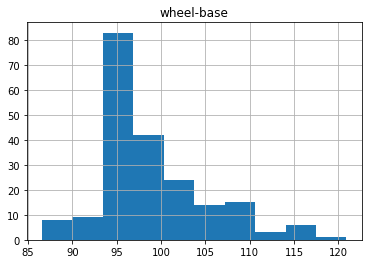

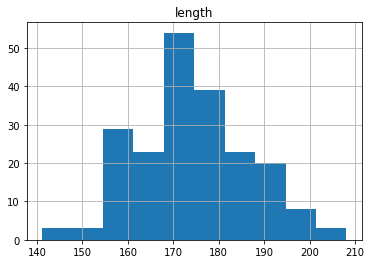

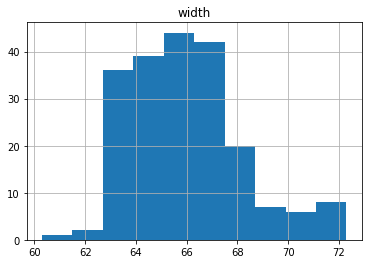

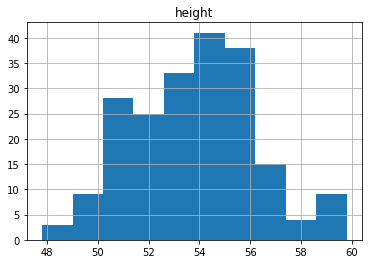

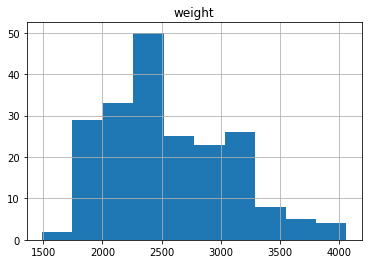

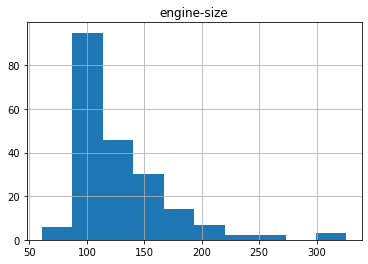

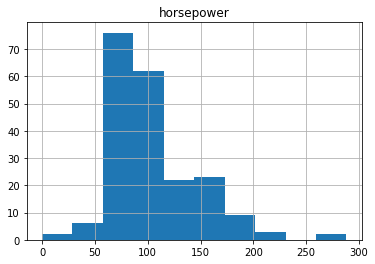

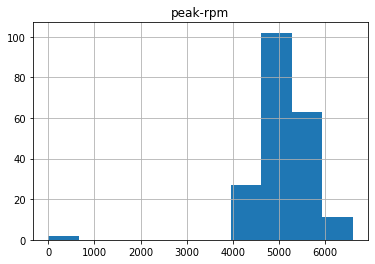

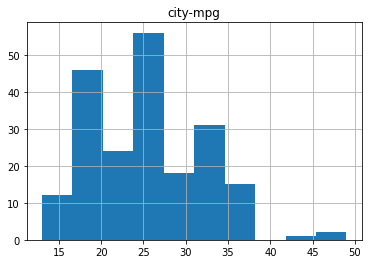

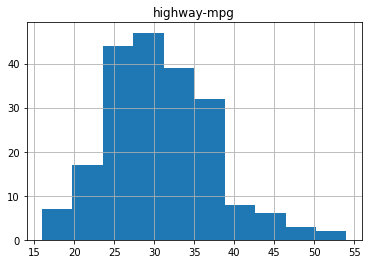

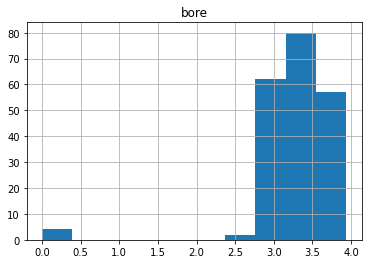

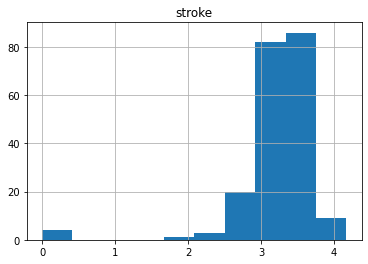

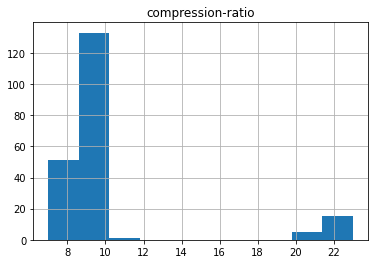

In [ ]:
# This 1D visualization of each numeric feature might inform your normalization
# decisions.
for feature_name in numeric_feature_names:
  car_data.hist(column=feature_name)

###Train your model with numeric features + normalization

['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7ffa868b28c0>), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7ffa868b29e0>), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7ffa868b2f80>), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7ffa868b2050>), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7ffa868ade60>), NumericColumn(key='height', shape=(1,), default_va

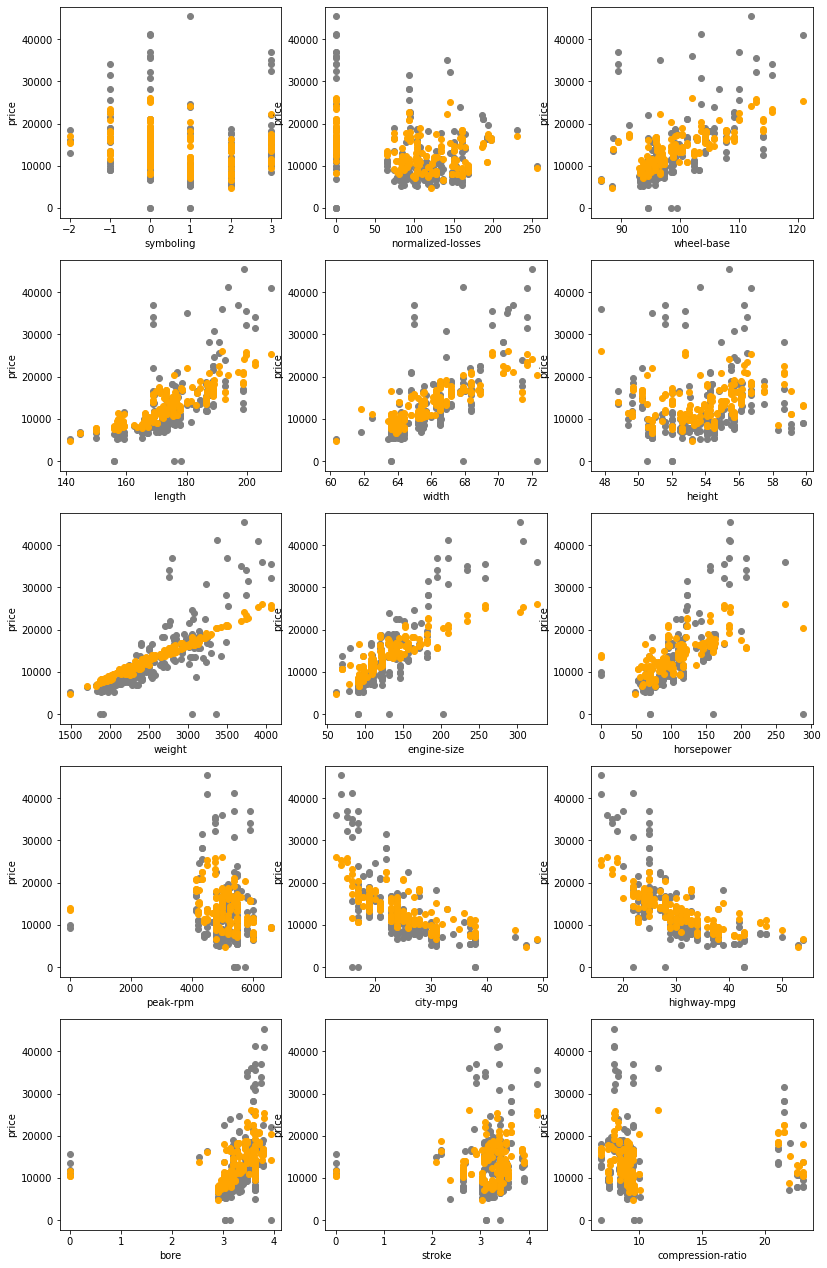

In [ ]:
## Your code goes here
batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Epsilon prevents divide by zero.
epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the 
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)

scatter_plot_inference_grid(est, x_df, numeric_feature_names)

In [ ]:
#@title Possible solution
# This does Z-score normalization since the distributions for most features looked
# roughly normally distributed.

# Z-score normalization subtracts the mean and divides by the standard deviation,
# to give a roughly standard normal distribution (mean = 0, std = 1) under a
# normal distribution assumption. Epsilon prevents divide by zero.

# With normalization, are you able to get the model working with
# GradientDescentOptimizer? Z-score normalization doesn't seem to be able to get
# SGD working. Maybe a different type of normalization would?

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Epsilon prevents divide by zero.
epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the 
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)

scatter_plot_inference_grid(est, x_df, numeric_feature_names)

## Task 3: Make your best model using only categorical features

- Look at the possible feature columns for categorical features. They begin with `categorical_column_with_` in go/tf-ops.
- You may find `dataframe[categorical_feature_names].unique()` helpful.


In [ ]:
## Your code goes here
batch_size = 16

x_df = car_data[categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  print('scores', scores)

model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='drive-wheels', vocabulary_list=('fwd', 'rwd', '4wd'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='engine-type', vocabulary_list=('ohc', 'dohc', 'ohcf', 'ohcv', 'rotor', 'l', 'dohcv'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-doors', vocabulary_list=('two', 'four', '?'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='body-style', vocabulary_list=('hatchback', 'sedan', 'wagon', 'hardtop', 'convertible'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-cylinders', vocabulary_list=('four', 'six', 'two', 'five', 'eight', 'three', 'twelve'), dtype=tf.string, defaul

In [ ]:
#@title Possible solution
# We have the full list of values that each feature takes on, and the list is
# relatively small so we use categorical_column_with_vocabulary_list.

batch_size = 16

x_df = car_data[categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



## Task 4: Using all the features, make the best model that you can make

With all the features combined, your model should perform better than your earlier models using numerical and categorical models alone. Tune your model until that is the case.

In [ ]:
## Your code goes here
batch_size = 16

x_df = car_data[numeric_feature_names + categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
] + [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]


print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  print('scores', scores)

model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='drive-wheels', vocabulary_list=('fwd', 'rwd', '4wd'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='engine-type', vocabulary_list=('ohc', 'dohc', 'ohcf', 'ohcv', 'rotor', 'l', 'dohcv'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-doors', vocabulary_list=('two', 'four', '?'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='body-style', vocabulary_list=('hatchback', 'sedan', 'wagon', 'hardtop', 'convertible'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-cylinders', vocabulary_list=('four', 'six', 'two', 'five', 'eight', 'three', 'twelve'), dtype=tf.string, defaul

In [ ]:
#@title Possible solution
# This is a first pass at a model that uses all the features.
# Do you have any improvements?

batch_size = 16

x_df = car_data[numeric_feature_names + categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
] + [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]


print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the 
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)